# 4-2 강남역 맛집 리뷰로 알아보는 감성 분류

## 크롤링: 카카오맵 리뷰 크롤링

### [카카오맵 검색 결과로 나오는 고기집 상세페이지 url 정보 구하기]

In [3]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from selenium import webdriver
from bs4 import BeautifulSoup
import re

In [11]:
import time
from selenium.webdriver.common.by import By

# brew로 설치된 chromedriver의 path (Mac)
path = "/Users/yanghaejun/opt/homebrew/Caskroom/chromedriver/chromedriver_mac64/chromedriver"

# 크롤링할 사이트 주소 정의
source_url = "https://map.kakao.com/"

# 크롬드라이버 사용
driver = webdriver.Chrome(path)

# 카카오 지도에 접속
driver.get(source_url)

# 검색창에 검색어를 입력함
searchbox = driver.find_element(By.XPATH, "//input[@id='search.keyword.query']")
searchbox.send_keys("강남역 고기집")

# 검색버튼을 눌러서 결과를 가져옴
searchbutton = driver.find_element(By.XPATH, "//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click();", searchbutton)

# 검색 결과를 가져올 시간을 기다림
time.sleep(2)

# 검색 결과의 페이지 소스를 가져옴
html = driver.page_source

# BeautifulSoup을 이용하여 html 정보를 파싱
soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name = "a", attrs = {"class": "moreview"})

# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성
page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용한 브라우저를 종료
driver.close()

https://place.map.kakao.com/95713992
https://place.map.kakao.com/2011092566
https://place.map.kakao.com/741391811
https://place.map.kakao.com/1503746075
https://place.map.kakao.com/1052874675
https://place.map.kakao.com/168079537
https://place.map.kakao.com/1648266796
https://place.map.kakao.com/27238067
https://place.map.kakao.com/26573718
https://place.map.kakao.com/263830255
https://place.map.kakao.com/1511737742
https://place.map.kakao.com/1780387311
https://place.map.kakao.com/56929632
https://place.map.kakao.com/27511865
https://place.map.kakao.com/1907052666


### [가져온 맛집 리스트의 리뷰 정보 크롤링하기]

In [12]:
columns = ["review"]
df = pd.DataFrame(columns = columns)

driver = webdriver.Chrome(path)

for page_url in page_urls:
    driver.get(page_url)
    time.sleep(1)

    # 더보기 버튼을 2번 클릭
    for _ in range(7):
        try:
            # xpath 참고 블로그(https://wkdtjsgur100.github.io/selenium-xpath/)
            many_reviews = driver.find_element(By.XPATH, "//div[@class='evaluation_review']/a[@class='link_more']")
            many_reviews.click()
            time.sleep(1)
        except:
            pass

    try:
        # "후기 더보기"를 5번 클릭한 상태의 html로 파싱
        html = driver.page_source
        soup = BeautifulSoup(html, "html.parser")
        contents_div = soup.find(name = "div", attrs = {"class": "evaluation_review"})

        # 그 후 리뷰를 가져옴
        reviews = contents_div.find_all(name = "p", attrs = {"class": "txt_comment"})
        for review in reviews:
            row = review.find(name = "span").text
            series = pd.Series(row, index = df.columns)
            df = df.append(series, ignore_index = True)
    except:
        # 리뷰 페이지가 없는 경우 수행하지 않음
        print(page_url)
        continue

driver.close()

https://place.map.kakao.com/2011092566
https://place.map.kakao.com/27238067
https://place.map.kakao.com/263830255


In [13]:
# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출합니다
df = df[df["review"].str.len() > 0]
df = df.reset_index()

# review_data의 score를 가져옴
review = pd.read_csv("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/chapter4/review_data.csv")
review = review.iloc[:len(df), :]
score = review["score"]
score_data = pd.DataFrame(score)

# df와 score_data를 병합
df = df.join(score_data)
df = df[["score", "review"]]
df

,score,review
0,5,강남역에서 닭갈비 먹고 싶을 때가면 좋을 것 같아요런치로 먹으니 가격도 저렴하고치즈...
1,4,사람이 너무 많기도 하고 공간이 너무 좁아서 힘들었어요ㅠㅠㅠ 그리고 가격이 좀 비싸...
2,4,위생 개판이고 컵에 드러운거 덕지덕지 붙어있어요.제발 좀 닦으세요! 그리고 부탄가스...
3,5,맛도 특색없고 비위생적이었어요..!
4,5,"닭갈비는 1인분에 11,000원이구요. 사진은 닭갈비 2인분 주문해서 음식 나오자마..."
...,...,...
344,5,꽃삼겹 미쳤습니다... 목살도 묵직하고 좋아요 .. 가격이 있지만 충분히 그 값을 ...
345,5,무난무난 체인이라 거기서 거기
346,1,교대에 있는 이층집 자주가서 갔는데 반찬수도 뭔가 작고 엄청 불친절하네요.. 교대 ...
347,5,장인어른과 장모님을 모시고 간곳중에 최고의 고깃집 왠만해선 장인 장모가 극찬을 하는...


In [14]:
# 4점 이상의 리뷰는 긍정리뷰(1), 3점 이하의 리뷰는 부정 리뷰(0)로 평가
df["y"] = df["score"].apply(lambda x: 1 if float(x) > 3 else 0)

# df를 csv파일로 저장
df.to_csv("/Users/yanghaejun/Desktop/reviewdata.csv", index = False)

In [15]:
df

,score,review,y
0,5,강남역에서 닭갈비 먹고 싶을 때가면 좋을 것 같아요런치로 먹으니 가격도 저렴하고치즈...,1
1,4,사람이 너무 많기도 하고 공간이 너무 좁아서 힘들었어요ㅠㅠㅠ 그리고 가격이 좀 비싸...,1
2,4,위생 개판이고 컵에 드러운거 덕지덕지 붙어있어요.제발 좀 닦으세요! 그리고 부탄가스...,1
3,5,맛도 특색없고 비위생적이었어요..!,1
4,5,"닭갈비는 1인분에 11,000원이구요. 사진은 닭갈비 2인분 주문해서 음식 나오자마...",1
...,...,...,...
344,5,꽃삼겹 미쳤습니다... 목살도 묵직하고 좋아요 .. 가격이 있지만 충분히 그 값을 ...,1
345,5,무난무난 체인이라 거기서 거기,1
346,1,교대에 있는 이층집 자주가서 갔는데 반찬수도 뭔가 작고 엄청 불친절하네요.. 교대 ...,0
347,5,장인어른과 장모님을 모시고 간곳중에 최고의 고깃집 왠만해선 장인 장모가 극찬을 하는...,1


## 텍스트 전처리: TF-IDF를 이용한 핵심어 추출

### [한글 텍스트로 전처리하기]

In [4]:
# 텍스트 정제함수: 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub(repl = '', string = text)
    return result

In [5]:
# 저장한 df 파일 가져오기
df = pd.read_csv("/Users/yanghaejun/Desktop/reviewdata.csv")

# 함수를 적용하여 리뷰에서 한글만 추출합니다.
df["ko_text"] = df["review"].apply(lambda x: text_cleaning(x))
df = df.drop("review", axis = 1)
df

,score,y,ko_text
0,5,1,강남역에서 닭갈비 먹고 싶을 때가면 좋을 것 같아요런치로 먹으니 가격도 저렴하고치즈...
1,4,1,사람이 너무 많기도 하고 공간이 너무 좁아서 힘들었어요ㅠㅠㅠ 그리고 가격이 좀 비싸...
2,4,1,위생 개판이고 컵에 드러운거 덕지덕지 붙어있어요제발 좀 닦으세요 그리고 부탄가스좀 ...
3,5,1,맛도 특색없고 비위생적이었어요
4,5,1,닭갈비는 인분에 원이구요 사진은 닭갈비 인분 주문해서 음식 나오자마자 전혀 손도 안...
...,...,...,...
343,5,1,꽃삼겹 미쳤습니다 목살도 묵직하고 좋아요 가격이 있지만 충분히 그 값을 합니다 디...
344,5,1,무난무난 체인이라 거기서 거기
345,5,1,교대에 있는 이층집 자주가서 갔는데 반찬수도 뭔가 작고 엄청 불친절하네요 교대 생각...
346,1,0,장인어른과 장모님을 모시고 간곳중에 최고의 고깃집 왠만해선 장인 장모가 극찬을 하는...


### [형태 단위의 추출 함수 정의하기]

In [12]:
from konlpy.tag import Okt

# konply 라이브러리로 텍스트 데이터에서 형태소를 추출
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ["{}/{}".format(word, tag) for word, tag in pos]
    return pos

# 형태소 추출 동작을 테스트
result = get_pos(df['ko_text'][0])
print(result)

['강남역/Noun', '에서/Josa', '닭갈비/Noun', '먹고/Verb', '싶을/Verb', '때/Noun', '가면/Noun', '좋을/Adjective', '것/Noun', '같아/Adjective', '요런/Modifier', '치/Noun', '로/Josa', '먹으니/Verb', '가격/Noun', '도/Josa', '저렴하고/Adjective', '치즈/Noun', '양도/Noun', '진짜/Noun', '많더라구요/Adjective', '사리/Noun', '추가/Noun', '해서/Verb', '먹으니/Verb', '배/Noun', '터질/Verb', '뻔/Noun', '했어요/Verb', 'ㅋㅋ/KoreanParticle', '평일/Noun', '오후/Noun', '시/Noun', '이후/Noun', '에/Josa', '가야/Noun', '웨이/Noun', '팅/Noun', '안/Noun', '하고/Verb', '바로/Noun', '먹을/Verb', '수/Noun', '있을/Adjective', '것/Noun', '같아요/Adjective']


### [분류 모델의 학습 데이터로 변환하기: corpus index 생성]

In [139]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df["ko_text"].tolist())
print(X.shape)

(349, 3083)


In [134]:
print(str(index_vectorizer.vocabulary_)[:100] + "..")

{'강남역/Noun': 122, '에서/Josa': 1964, '닭갈비/Noun': 661, '먹고/Verb': 1033, '싶을/Verb': 1689, '때/Noun': 851,..


In [35]:
print(df["ko_text"][1])
print(X[1])

사람이 너무 많기도 하고 공간이 너무 좁아서 힘들었어요ㅠㅠㅠ 그리고 가격이 좀 비싸네요맛은 괜찮았습니다만 웨이팅 할만하지는 않은 것 같습니다
  (0, 184)	1
  (0, 23)	1
  (0, 2119)	1
  (0, 2821)	1
  (0, 2878)	1
  (0, 1470)	1
  (0, 2167)	3
  (0, 552)	2
  (0, 943)	1
  (0, 235)	1
  (0, 2471)	1
  (0, 3081)	1
  (0, 19)	1
  (0, 368)	1
  (0, 2469)	1
  (0, 1427)	1
  (0, 971)	1
  (0, 2152)	1
  (0, 255)	1
  (0, 2947)	1
  (0, 941)	1
  (0, 2570)	1
  (0, 1839)	1
  (0, 131)	1


### [분류 모델의 학습 데이터로 변환하기: TF-IDF로 변환]

In [36]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [61]:
print(df["ko_text"][3])
print(X.shape)
print(X[3])

맛도 특색없고 비위생적이었어요
(349, 3083)
  (0, 2814)	0.4850208242407046
  (0, 2211)	0.4850208242407046
  (0, 1930)	0.38763686709480244
  (0, 1438)	0.546463260324582
  (0, 971)	0.21728221371478612
  (0, 721)	0.18279388417912604


## 분류: 긍정/부정 리뷰 분류하기

### [분류 모델링: 데이터셋 분리]

In [102]:
from sklearn.model_selection import train_test_split

y = df["y"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(244, 3083)
(105, 3083)
(244,)
(105,)


### [분류 모델링: 로지스틱 회귀 모델]

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# 로지스틱 회귀 모델을 학습
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1]

# 로지스틱 회귀 모델의 성능을 평가
print("Accuracy: %.3f" % accuracy_score(y_test, y_pred))
print("Precision: %.3f" % precision_score(y_test, y_pred))
print("Recall: %.3f" % recall_score(y_test, y_pred))
print("F1: %.3f" % f1_score(y_test, y_pred))

Accuracy: 0.610
Precision: 0.604
Recall: 0.984
F1: 0.748


In [104]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[ 3 40]
 [ 1 61]]


AUC: 0.575


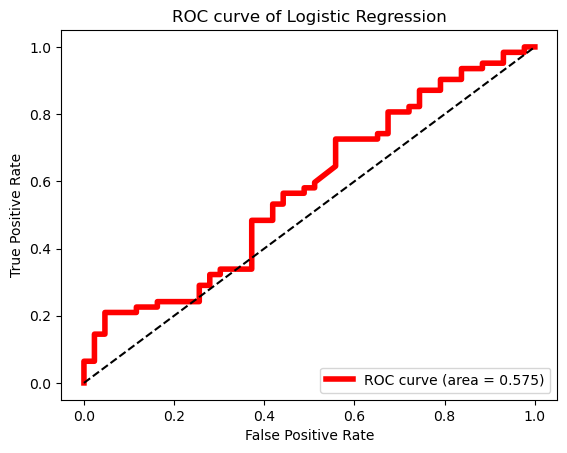

In [105]:
# AUC를 계산
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC: %.3f" % roc_auc)

# ROC curve 그래프를 출력
plt.plot(false_positive_rate, true_positive_rate, color = "red", linewidth = 4.0, label = "ROC curve (area = %.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC curve of Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.show()

### [클래스 불균형 문제 해결하기]

In [106]:
# y가 0과 1을 각각 얼마나 가지고 있는지를 출력
df["y"].value_counts()

1    204
0    145
Name: y, dtype: int64

In [107]:
# 1:1 비율로 랜덤 샘플링을 수행
positive_random_idx = df[df["y"] == 1].sample(50, random_state = 30).index.tolist()
negative_random_idx = df[df["y"] == 0].sample(50, random_state = 30).index.tolist()

# 랜덤 데이터로 데이터셋을 나눔
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df.loc[random_idx, "y"]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size = 0.30)
print(x_train.shape)
print(x_test.shape)

(70, 3083)
(30, 3083)


### [로지스틱 회귀 모델 다시 학습하기]

In [111]:
# 로지스틱 회귀 모델을 다시 학습
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1]

# 학습 모델을 테스트 데이터로 평가
print("Accuracy: %.3f" % accuracy_score(y_test, y_pred))
print("Precision: %.3f" % precision_score(y_test, y_pred))
print("Recall: %.3f" % recall_score(y_test, y_pred))
print("F1: %.3f" % f1_score(y_test, y_pred))

# Confusion Matrix를 출력
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

Accuracy: 0.533
Precision: 0.556
Recall: 0.333
F1: 0.417
[[11  4]
 [10  5]]


AUC: 0.596


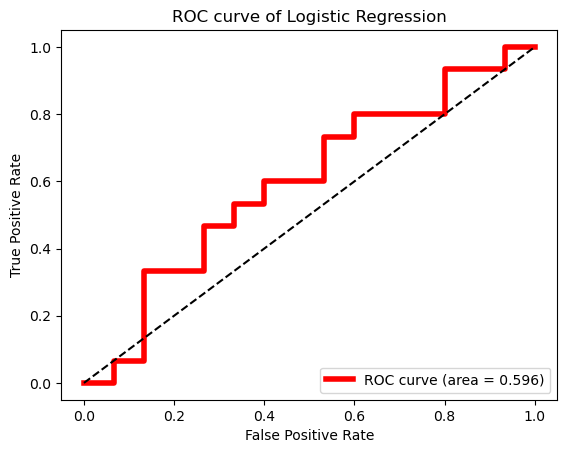

In [113]:
# AUC score
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC: %.3f" % roc_auc)

# ROC curve 그래프를 출력
plt.plot(false_positive_rate, true_positive_rate, color = "red", linewidth = 4.0, label = "ROC curve (area = %.3f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC curve of Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc = "lower right")
plt.show()

# 분석: 중요 키워드 분석하기

### [회귀 모델의 피처 영향력 추출하기]

[(0.45450462262843583, 2466), (0.40913758950901097, 1546), (0.38870997238119576, 1225), (0.38571696770794595, 1242), (0.3228395181424807, 234)]
[(-0.2916523254485958, 2717), (-0.2928731247518086, 1125), (-0.30346737476039826, 2276), (-0.3930436121938196, 262), (-0.3930436121938196, 2735)]


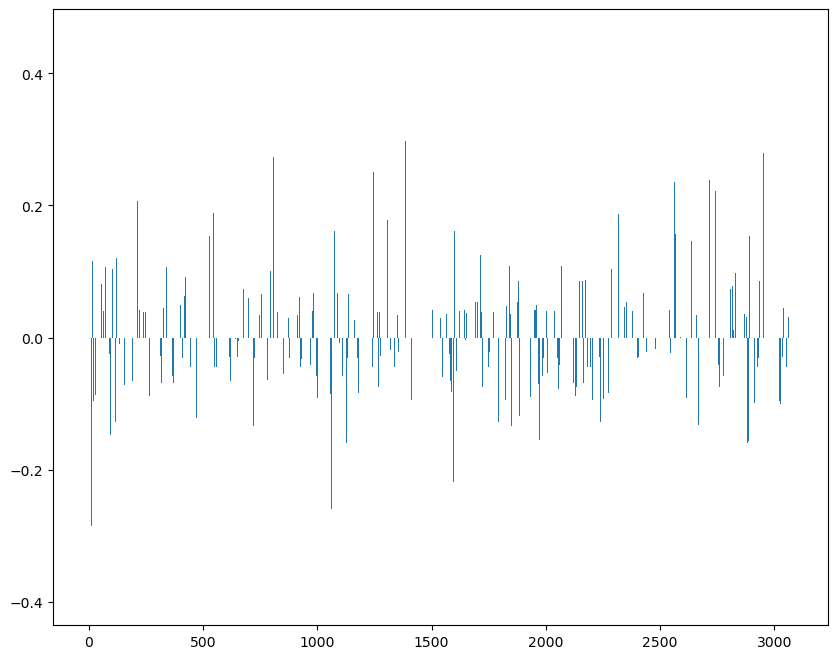

In [130]:
# 학습한 회귀 모델의 계수를 출력
plt.rcParams["figure.figsize"] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), key = lambda x: x[0], reverse = True)[:5])
print(sorted(((value, index) for (index, value) in enumerate(lr.coef_[0])), key = lambda x: x[0], reverse = True)[-5:])
plt.show()

### [중요 변수의 형태소]

In [133]:
# 회귀 모델의 계수를 높은 순으로 정렬
coef_pos_index = sorted(((value, index) for (index, value) in enumerate(lr.coef_[0])), reverse = True)

# 회귀 모델의 계수를 index_vectorizer에 맵핑하여 어떤 형태소인지 출력할 수 있게 함
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로 피처에 형태소를 맵핑한 결과를 출력, 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있음
print(str(invert_index_vectorizer)[:100] + "..")

{122: '강남역/Noun', 1964: '에서/Josa', 661: '닭갈비/Noun', 1033: '먹고/Verb', 1689: '싶을/Verb', 851: '때/Noun',..


### [상위 20개 긍정 형태소 출력하기]

In [136]:
# 상위 20개 긍정 형태소를 출력
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

존맛/Noun 0.45450462262843583
성지/Noun 0.40913758950901097
반찬/Noun 0.38870997238119576
방문/Noun 0.38571696770794595
곳/Noun 0.3228395181424807
ㄹㅇ/KoreanParticle 0.31151964945119953
블랙리스트/Noun 0.3081347855732657
불친절해요/Adjective 0.297682566831516
함/Noun 0.2790448863024859
는/Josa 0.27767837973668913
성지순례/Noun 0.2742192594159363
들/Suffix 0.2729227032815133
최고/Noun 0.2728040261993058
굿/Noun 0.27190566419420487
옴/Noun 0.2704462629384071
맛있습니다/Adjective 0.26330784098560195
저렴하고/Adjective 0.25921283805486406
탱/Adverb 0.25827191209935335
배/Noun 0.25108235511388516
맛있게/Adjective 0.24296266759232074
